In [1]:
import torch

# Check if MPS is available
print("MPS available:", torch.backends.mps.is_available())

# Check if MPS is built
print("MPS built:", torch.backends.mps.is_built())

# Check current device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Current device:", device)

MPS available: True
MPS built: True
Current device: mps


<h4> # Import all modules

In [2]:
from data_loader import load_images, split_data
from preprocessing import preprocess_all_images,expand_channels_for_split,get_augmentation_transform,show_random_clahe_images_per_label,preprocess_image_cv2
from dataset import MergedImagesDataset
from model import get_resnet18_model,get_resnet18_model_layer_added, get_mobilenetv2_model,get_mobilenetv2_model_layer_added,get_efficientnetb0_model_layer_added,get_efficientnetv2_s_model_layer_added
from train import train_model_with_val
from evaluate import evaluate_model
from utils import EarlyStoppingWithLR, save_best_model_state
from grad_cam import show_grad_cam_for_random_images_per_label
import mlflow
from torchinfo import summary
import torch
from mlflow_log import log_after_evaluation, log_after_training, log_before_training


In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Blade_Surface_Defect_Detection")

<Experiment: artifact_location='mlflow-artifacts:/391082854141916189', creation_time=1756969234152, experiment_id='391082854141916189', last_update_time=1756969234152, lifecycle_stage='active', name='Blade_Surface_Defect_Detection', tags={}>

<h4> # 1. Load images and labels <h4>

Loaded 400 images with 3 unique labels using cv2
Image count per label:
  Nick: 48
  Scratch: 149
  Good: 203


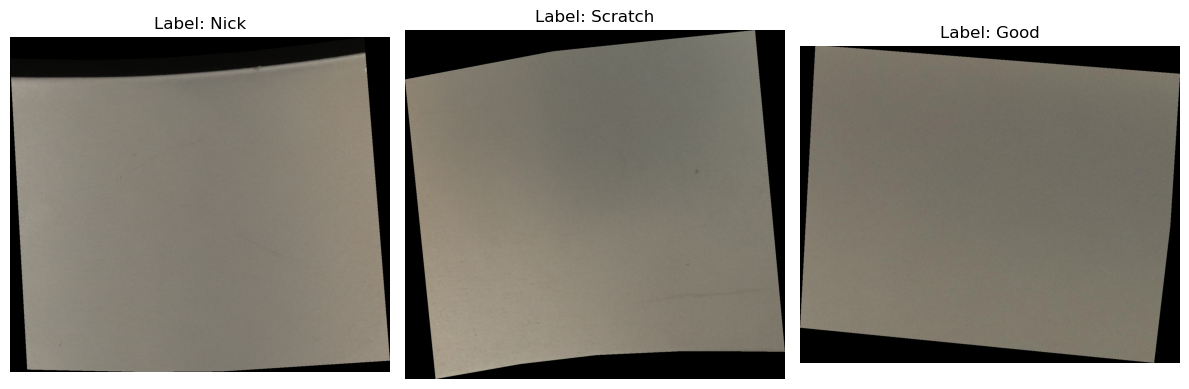

In [4]:
images, labels = load_images()
#labels = ['Good' if l == 'Good' else 'Defective' for l in labels] ## Binary mapping


<h4> # 2. Preprocess images <h4>

In [5]:
clahe_images = preprocess_all_images(images)

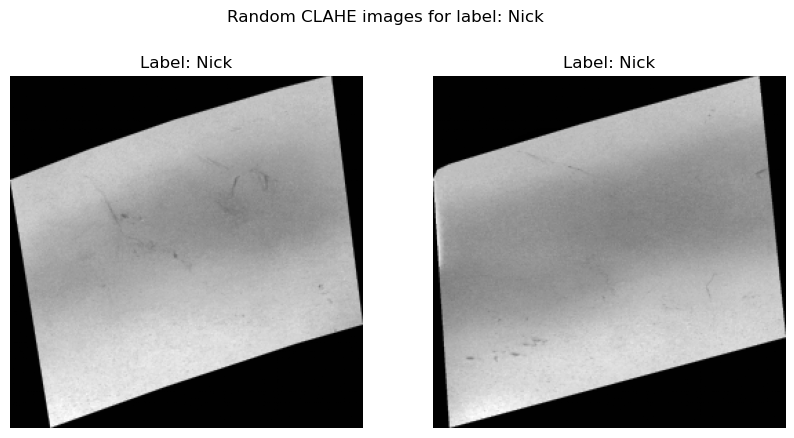

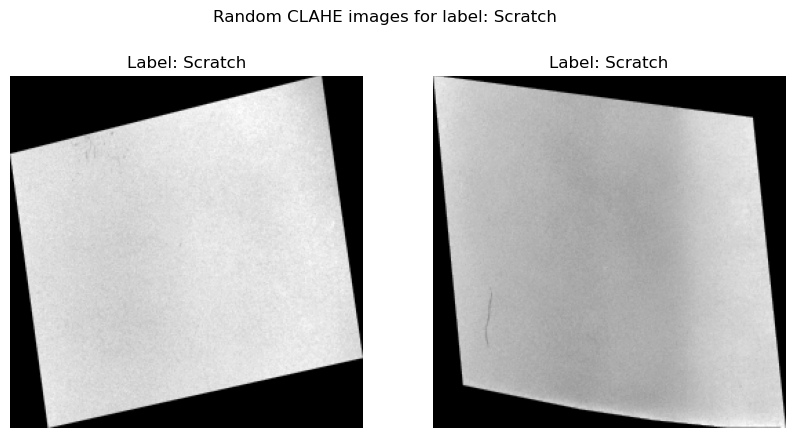

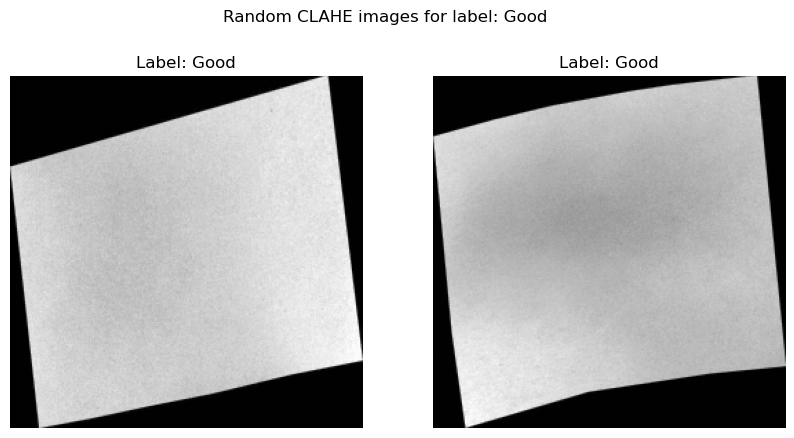

In [6]:
show_random_clahe_images_per_label(clahe_images, labels, n_per_label=2)

<h4> # 3. Split data. <h4>

In [7]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(list(clahe_images),labels)

Train: 280, Validation: 60, Test: 60


<h4> # 4. Expand channels for compatibility with pretrained models <h4>

In [8]:
x_train_exp, x_val_exp, x_test_exp = expand_channels_for_split(x_train, x_val, x_test)

<h4> # 5. Prepare label mapping <h4>

In [9]:
unique_labels = sorted(set(labels))
label_to_idx = {label: idx for idx , label in enumerate(unique_labels)}

<h4> # 6. Data augmentation <h4>

In [10]:
transform = get_augmentation_transform()

<h4> Parameters <h4>

In [11]:
num_epochs=50
lr_rate=1e-4
batch_size=32

<h4> # 7. Create datasets and dataloaders

In [12]:
train_dataset = MergedImagesDataset(x_train_exp, y_train, label_to_idx, transform=transform)
val_dataset = MergedImagesDataset(x_val_exp, y_val, label_to_idx)
test_dataset = MergedImagesDataset(x_test_exp, y_test, label_to_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


<h4> # 8. Model, loss, optimizer, scheduler <h4>

In [13]:
device = torch.device('mps')
num_classes = len(unique_labels)
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr_rate, weight_decay=1e-5)
early_stopper = EarlyStoppingWithLR(optimizer, patience=4, lr_patience=2, factor=0.7)


<h4> # 9. Train and Evaluate <h4>


Epoch 1/50 - Loss: 1.0635 - Acc: 0.4643 | Val Loss: 1.1065 - Val Acc: 0.2333
Epoch 2/50 - Loss: 0.9797 - Acc: 0.5571 | Val Loss: 1.0794 - Val Acc: 0.4667
Epoch 3/50 - Loss: 0.8911 - Acc: 0.6214 | Val Loss: 0.9845 - Val Acc: 0.7167
Epoch 4/50 - Loss: 0.8086 - Acc: 0.6321 | Val Loss: 0.7710 - Val Acc: 0.8000
Epoch 5/50 - Loss: 0.6613 - Acc: 0.7500 | Val Loss: 0.5336 - Val Acc: 0.8500
Epoch 6/50 - Loss: 0.5683 - Acc: 0.7750 | Val Loss: 0.3659 - Val Acc: 0.8833
Epoch 7/50 - Loss: 0.4741 - Acc: 0.8000 | Val Loss: 0.2821 - Val Acc: 0.8833
Epoch 8/50 - Loss: 0.4974 - Acc: 0.7929 | Val Loss: 0.2463 - Val Acc: 0.9333
Epoch 9/50 - Loss: 0.3551 - Acc: 0.8643 | Val Loss: 0.2900 - Val Acc: 0.9000
Epoch 10/50 - Loss: 0.3573 - Acc: 0.8857 | Val Loss: 0.2647 - Val Acc: 0.8833
Reducing learning rate: 1.00e-04 -> 7.00e-05
Epoch 11/50 - Loss: 0.2886 - Acc: 0.8893 | Val Loss: 0.2565 - Val Acc: 0.9000
Epoch 12/50 - Loss: 0.3044 - Acc: 0.8964 | Val Loss: 0.3258 - Val Acc: 0.8667
Reducing learning rate: 7.00

2025/09/05 14:33:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'EfficientNetV2S_BladeDefect_20ab2bd7'.
2025/09/05 14:33:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: EfficientNetV2S_BladeDefect_20ab2bd7, version 1
Created version '1' of model 'EfficientNetV2S_BladeDefect_20ab2bd7'.


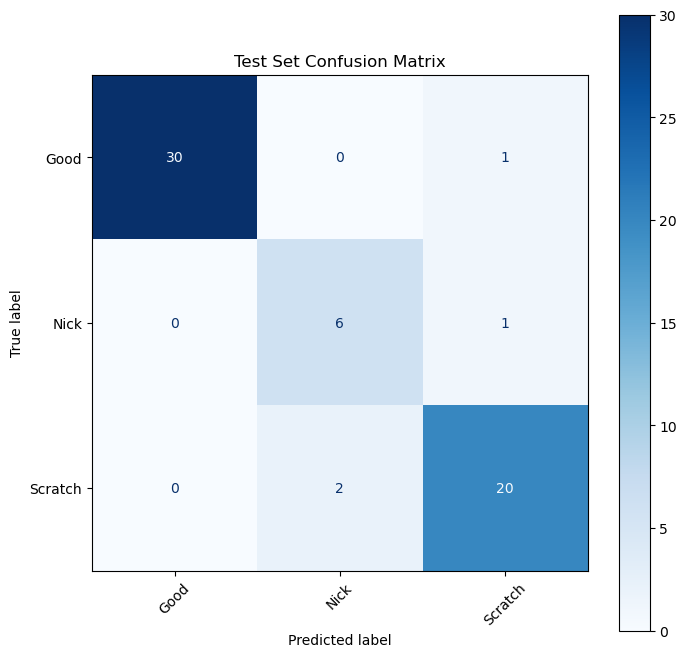

🏃 View run judicious-flea-669 at: http://127.0.0.1:8080/#/experiments/391082854141916189/runs/20ab2bd7880049959413d462cbcbffe4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/391082854141916189


In [14]:
with mlflow.start_run() as run:

    log_before_training(num_epochs, lr_rate, batch_size, criterion, model)

    loss_history, acc_history, val_loss_history, val_acc_history = train_model_with_val(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopper=early_stopper
    )
    save_best_model_state(early_stopper.best_state, "models/best_model_4.pth")
    log_after_training(model, test_loader, device, run.info.run_id)
    report = evaluate_model(model, test_loader, device, unique_labels)
    log_after_evaluation(report, unique_labels)


<h4> # 11 Grad-Cam <h4>

Processing label: Good, number of images: 31


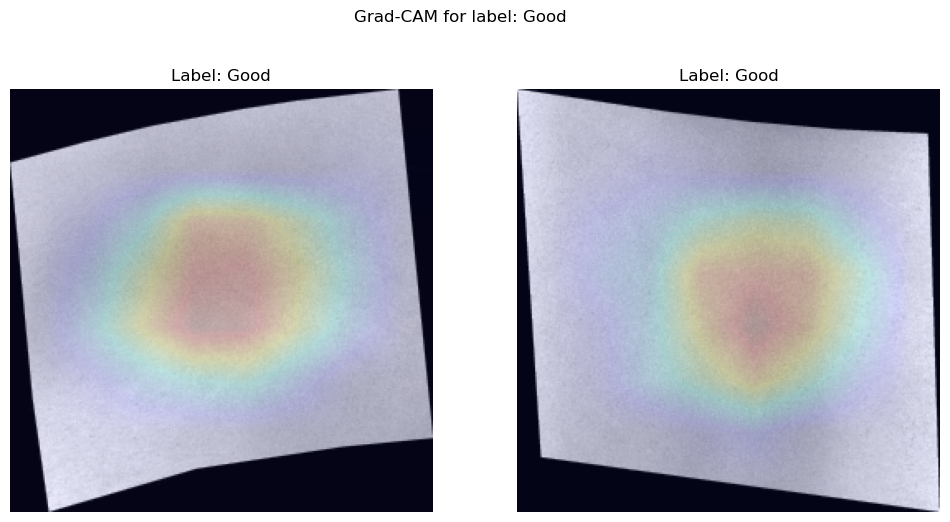

Processing label: Nick, number of images: 7


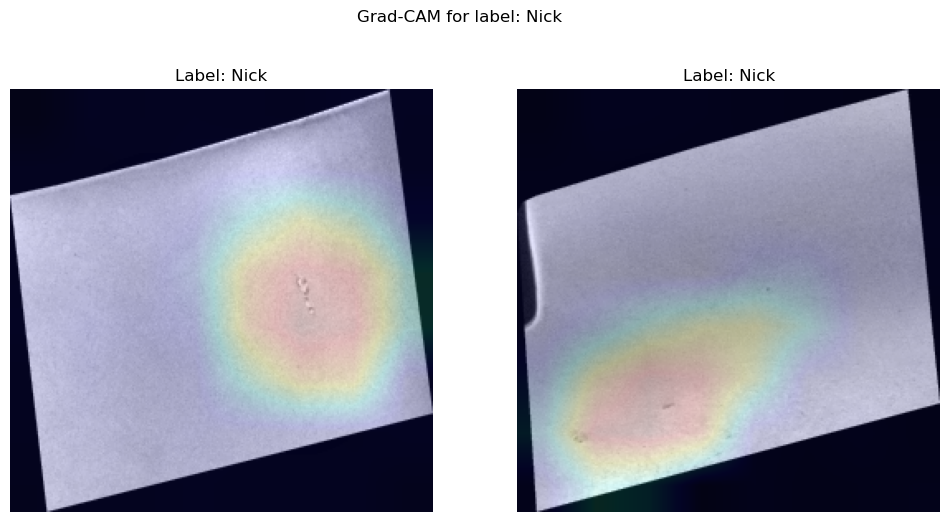

Processing label: Scratch, number of images: 22


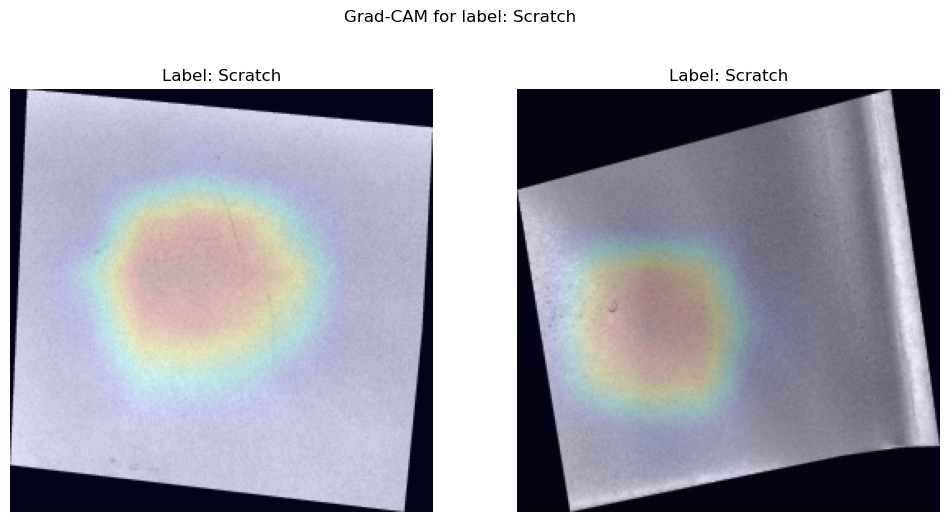

In [15]:
# Grad-CAM visualization for 2 random images per label (using numpy arrays)
num_classes = len(unique_labels)  # or the correct number for your task
model = get_efficientnetv2_s_model_layer_added(num_classes, freeze=False)
model.load_state_dict(torch.load("models/best_model.pth", map_location=device))
model.to(device)
model.eval()
show_grad_cam_for_random_images_per_label(model, test_dataset, labels, label_to_idx, device, n_per_label=2)

